In [1]:
import numpy as np
import pandas as pd
import os,sys
import datetime 
from datetime import timedelta
import matplotlib.pyplot as plt  ### We are going to plot the results in this notebook
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import matplotlib
import numpy as np
from mpl_toolkits.basemap import Basemap
%matplotlib nbagg


from Functions_for_animations import indices,compute_derivative,id_names_txt,avaliable_stations_vel,derivative,table_for_animation


2023-08-03 17:54:05.322777: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-03 17:54:05.340664: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Enter the root directory folder:  /home/giacomo/Documents/


Directory found: /home/giacomo/Documents/Denoiser_GPS/sharing_gratsid_tf_in_development
Num GPUs Available:  0
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### Set Imput folder - Area

In [47]:
cd='/home/giacomo/Documents/Cascadia/'

#Cascadia:

Width=475000
Height=750000

lat_1=44
lat_2=np.amax(df.latitude)
lat_0=46.7
lon_0=-124

In [48]:
############## I falsify latitude e longitude of the stations with exactly the same location ##############
df = pd.read_csv(cd+'stations_coordinates.txt', delimiter=',',names=['station','latitude','longitude','height'],header=None)
latitude=list(df.latitude)
longitude=list(df.longitude)

duplicates_longitudes=dict((x, indices(longitude, x)) for x in set(longitude) if longitude.count(x) > 1) # Find  
for i in list(duplicates_longitudes.values()):
    longitude[i[1]]=longitude[i[1]]+0.00001

duplicates_latitudes=dict((x, indices(latitude, x)) for x in set(latitude) if latitude.count(x) > 1)
for i in list(duplicates_latitudes.values()):
    latitude[i[1]]=latitude[i[1]]+0.00001

df.latitude=latitude
df.longitude=longitude
print('Imported')

Imported


### Period of interest

In [49]:
t = np.arange(datetime.datetime(2015,1,1), datetime.datetime(2023,1,1), datetime.timedelta(days=1)).astype(datetime.datetime)

### Components and Flags

In [31]:
componentsT=['E','N','U'] 
#### Choose components ####
indC=[0,1] #,2
components=list(np.array(componentsT)[indC])
print('You are using these components: ',np.array(componentsT)[indC])
gratsid_flag=True
exp_flag=True


namesT=[]
if gratsid_flag==True and exp_flag==True:
    for c in components:
        namesT.append([c,'DL_'+c,'EMV_'+c,'GrAtSiD_'+c])
else:
    for c in components:
        namesT.append([c,'DL_'+c])
names = [item for sublist in namesT for item in sublist]
names = ['YYMMDD'] + names
print(names)


You are using these components:  ['E' 'N']
['YYMMDD', 'E', 'DL_E', 'EMV_E', 'GrAtSiD_E', 'N', 'DL_N', 'EMV_N', 'GrAtSiD_N']


### Set input_length, Derivative step and componets

In [32]:
input_length=31
to_end=3
position=input_length-to_end
step=1

soln_folder_path=cd+'Filtered_'+str(input_length)+'_'+str(position)
vel_folder=soln_folder_path+'_vel_'+str(step)+'d'

if not os.path.exists(vel_folder):
    os.makedirs(vel_folder)
    print(vel_folder," created successfully")
    compute_derivative(soln_folder_path,step,names,vel_folder)
    print(vel_folder," Derivative computed successfully")
else:
    print(vel_folder," already exists")

/home/giacomo/Documents/Cascadia/Filtered_31_28_vel_1d  already exists


### Select Stations

In [37]:
save_flag=True
save_name=cd+'/velocities_'+str(input_length)+'_'+str(position)+'_'+str(t[0].date())+'_'+str(t[-1].date())+'.npz'
table=table_for_animation(t,list_stations,vel_folder,names,save_flag=True,save_name=save_name)

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


### Choose which quantity to plot

In [43]:
## Quiver properities
ww = 0.003
hh = 4
qscal = 3e-3

In [50]:
#### Check intersections between coordinates and txt files
filtered_df = df[df['station'].isin(list_stations)]

what_to_plot='DL' #GrAtSiD,EMV
what_c=[]

quali=[i for i in range(len(names)) if what_to_plot in names[i]]

### Make Plot

In [55]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
fig.subplots_adjust(wspace=0, hspace=0)
m = Basemap(ax=ax,width=Width,height=Height,projection='lcc',
            resolution='i',lat_1=lat_1,lat_2=lat_2,lat_0=lat_0,lon_0=lon_0)
m.drawcoastlines()
m.drawmapboundary(fill_color='white') 

f=0
Latitude=list(filtered_df.latitude)
Longitude=list(filtered_df.longitude)
Est=table[f,:,quali[0]]
North=table[f,:,quali[0]]

x,y = m(Longitude,Latitude)
ha_hor = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
ax.set_title('Current day: t = '+ str(t[f].date())+'\n'+'Velocity: '+ str(t[f-step].date())+' - '+str(t[f].date()),fontsize=8) 
ha_hor.remove()

ha_hor = None

def update(f):
    global ha_hor
     
    if ha_hor is not None:
        ha_hor.remove()
    Est=table[f,:,quali[0]]
    North=table[f,:,quali[1]]
    # Create a new quiver object for each frame
    ha_hor = m.quiver(x, y, np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal, scale_units='inches', color='blue', width=ww, headwidth=hh)

    ax.set_title('Current day: t = '+ str(t[f].date())+'\n'+'Velocity: '+ str(t[f-step].date())+' - '+str(t[f].date()),fontsize=8) 
   
    #line.set_data(x_data[:frame], y_data[:frame])
    #arrow.set_xy([x_data[frame], y_data[frame]])
    return 

#Create the animation
# Set the output file name
output_file = cd+"animation_output_"+str(input_length)+"_"+str(position)+".mp4"  # You can change the file name if needed
writers = animation.writers
writer = writers['ffmpeg']()
ani = FuncAnimation(fig, update, interval=2, frames=100)
ani.save(output_file, writer=writer, dpi=100)

<IPython.core.display.Javascript object>

### Animation with Subplots - vary position and step for computing the derivative 

In [15]:
Positions=[28,29,30]
Steps=[1,4]

In [16]:
STATIONS_TOT=[]

for ii in range(len(Steps)):
    STATIONS_step=[]
    step=Steps[ii]
    for kk in range(len(Positions)):
        Stations=[]
        position=Positions[kk]
        soln_folder_path=cd+'Filtered_'+str(input_length)+'_'+str(position)
        vel_folder=soln_folder_path+'_vel_'+str(step)+'d'
        print('Step: ',str(step),' - Position: ',str(position))
        list_stations=id_names_txt(vel_folder)
        Stations,dft=avaliable_stations_vel(vel_folder,list_stations,t,names)
        STATIONS_step.append(Stations)
    STATIONS_TOT.append(STATIONS_step)

Step:  1  - Position:  28
10%
20%
30%
40%
50%
60%
70%
80%
90%
Step:  1  - Position:  29
10%
20%
30%
40%
50%
60%
70%
80%
90%
Step:  1  - Position:  30
10%
20%
30%
40%
50%
60%
70%
80%
90%
Step:  4  - Position:  28
10%
20%
30%
40%
50%
60%
70%
80%
90%
Step:  4  - Position:  29
10%
20%
30%
40%
50%
60%
70%
80%
90%
Step:  4  - Position:  30
10%
20%
30%
40%
50%
60%
70%
80%
90%


#### Plot

In [57]:
## Quiver properities
ww = 0.003
hh = 4
qscal = 6e-3

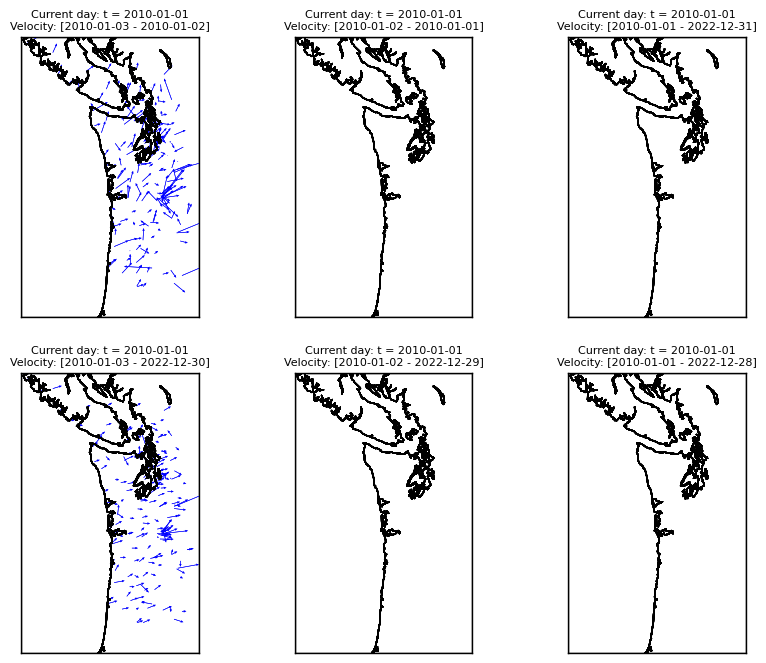

In [60]:
fig, axes = plt.subplots(len(Steps),len(Positions),figsize=(10,8))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

############ First plot ############
for ii in range(len(Steps)):
    step=Steps[ii]
    for kk in range(len(Positions)):
        position=Positions[kk]
        to_end=input_length-(Positions[kk]+1)
        m = Basemap(ax=axes[ii,kk],width=Width,height=Height,projection='lcc',
            resolution='i',lat_1=lat_1,lat_2=lat_2,lat_0=lat_0,lon_0=lon_0)
        m.drawcoastlines()
        m.drawmapboundary(fill_color='white') 
        
        STATIONS=STATIONS_TOT[ii][kk]
        North=[]
        Est=[]
        Up=[]
        Latitude=[]
        Longitude=[]
        
        f=0
        
        soln_folder_path=cd+'Filtered_'+str(input_length)+'_'+str(position)
        vel_folder=soln_folder_path+'_vel_'+str(step)+'d'
        #print('Step: ',str(step),' - Position: ',str(position))
        
        for k in range(len(STATIONS[f])):
            station=STATIONS[f][k][0]
            aa=vel_folder+'/'+str(station)+'.txt' 
            line_number = STATIONS[f][k][1]
            with open(aa, 'r') as file:
                for _ in range(line_number - 1):
                    file.readline()       
                line = file.readline() 
            split_line=line.split()
            Lat=float(filtered_df[filtered_df.station==station].latitude)
            Lon=float(filtered_df[filtered_df.station==station].longitude)
            E=split_line[quali[0]]
            N=split_line[quali[1]]
            
            Est.append(E)
            North.append(N)
            Latitude.append(Lat)
            Longitude.append(Lon)
        x,y = m(Longitude,Latitude)
        if kk==0 and ii==0:
            ha_hor00 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
        if kk==0 and ii==1:
            ha_hor01 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
        if kk==0 and ii==2:
            ha_hor02 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
        if kk==1 and ii==0:
            ha_hor10 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
        if kk==1 and ii==1:
            ha_hor11 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
        if kk==1 and ii==2:
            ha_hor12 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
        axes[ii,kk].set_title('Current day: t = '+ str(t[f].date())+'\n'+'Velocity: '+ str(t[f+to_end].date())+' - '+str(t[f+to_end-step].date()),fontsize=8) 
        # ha_hor.remove()


ha_hor00 = None
ha_hor01 = None
ha_hor02 = None
ha_hor10 = None
ha_hor11 = None
ha_hor12 = None
def update(f):
    global ha_hor00,ha_hor01,ha_hor02,ha_hor10,ha_hor11,ha_hor12

    for ii in range(len(Steps)):

        step=Steps[ii]
        for kk in range(len(Positions)):
            position=Positions[kk]
            to_end=input_length-(Positions[kk]+1)
            m = Basemap(ax=axes[ii,kk],width=Width,height=Height,projection='lcc',
                resolution='i',lat_1=lat_1,lat_2=lat_2,lat_0=lat_0,lon_0=lon_0)
            m.drawcoastlines()
            m.drawmapboundary(fill_color='white') 
            
            STATIONS=STATIONS_TOT[ii][kk]
            
            North=[]
            Est=[]
            Up=[]
            Latitude=[]
            Longitude=[]
            
            soln_folder_path=cd+'Filtered_'+str(input_length)+'_'+str(position)
            vel_folder=soln_folder_path+'_vel_'+str(step)+'d'
            
            for k in range(len(STATIONS[f])):
                station=STATIONS[f][k][0]
                aa=vel_folder+'/'+str(station)+'.txt'
                
                line_number = STATIONS[f][k][1]
                
                with open(aa, 'r') as file:
                    for _ in range(line_number - 1):
                        file.readline()       
                    line = file.readline()
                
                split_line=line.split()
                Lat=float(filtered_df[filtered_df.station==station].latitude)
                Lon=float(filtered_df[filtered_df.station==station].longitude)
                E=split_line[quali[0]]
                N=split_line[quali[1]]
                
                Est.append(E)
                North.append(N)
                Latitude.append(Lat)
                Longitude.append(Lon)
            x,y = m(Longitude,Latitude)
          
            if ii==0 and kk==0:
                if ha_hor00 is not None:
                    ha_hor00.remove()
                ha_hor00 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
            if ii==0 and kk==1:
                if ha_hor01 is not None:
                    ha_hor01.remove()
                ha_hor01 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
            if ii==0 and kk==2:
                if ha_hor02 is not None:
                    ha_hor02.remove()
                ha_hor02 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
            if ii==1 and kk==0:
                if ha_hor10 is not None:
                    ha_hor10.remove()
                ha_hor10 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
            if ii==1 and kk==1:
                if ha_hor11 is not None:
                    ha_hor11.remove()
                ha_hor11 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
            if ii==1 and kk==2:
                if ha_hor12 is not None:
                    ha_hor12.remove()
                ha_hor12 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
           
            
            axes[ii,kk].set_title('Current day: t = '+ str(t[f].date())+'\n'+'Velocity: ['+ str(t[f+to_end].date())+' - '+str(t[f+to_end-step].date())+']',fontsize=8) 
            # ha_hor.remove()
    return

output_file = cd+"Different_pos_step_"+str(input_length)+".mp4"  # You can change the file name if needed
writers = animation.writers
writer = writers['ffmpeg']()
ani = FuncAnimation(fig, update, interval=10, frames=range(len(Stations[0:20]) ))
ani.save(output_file, writer=writer, dpi=100)

### Plot DL vs ExpMv

In [77]:
input_length=31
to_end=3
position=input_length-to_end
to_end=input_length-position+1
step=1

soln_folder_path=cd+'Filtered_'+str(input_length)+'_'+str(position)
vel_folder=soln_folder_path+'_vel_'+str(step)+'d'

if not os.path.exists(vel_folder):
    os.makedirs(vel_folder)
    print(vel_folder," created successfully")
    compute_derivative(soln_folder_path,step,names,vel_folder)
    print(vel_folder," Derivative computed successfully")
else:
    print(vel_folder," already exists")

what_to_plot='DL' #GrAtSiD,EMV
what_to_plot2='EMV'
what_to_plot3='GrAtSiD'
what_c=[]

qualiDL=[i for i in range(len(names)) if what_to_plot in names[i]]
qualiEMV=[i for i in range(len(names)) if what_to_plot2 in names[i]]
qualiGrAtSiD=[i for i in range(len(names)) if what_to_plot3 in names[i]]

/home/giacomo/Documents/Cascadia/Filtered_31_28_vel_1d  already exists


In [78]:
list_stations=id_names_txt(vel_folder)
#### Check intersections between coordinates and txt files
filtered_df = df[df['station'].isin(list_stations)]
Stations,dft=avaliable_stations_vel(vel_folder,list_stations,t,names)

10%
20%
30%
40%
50%
60%
70%
80%
90%


In [79]:
## Quiver properities
ww = 0.003
hh = 4
qscal = 7e-3

End


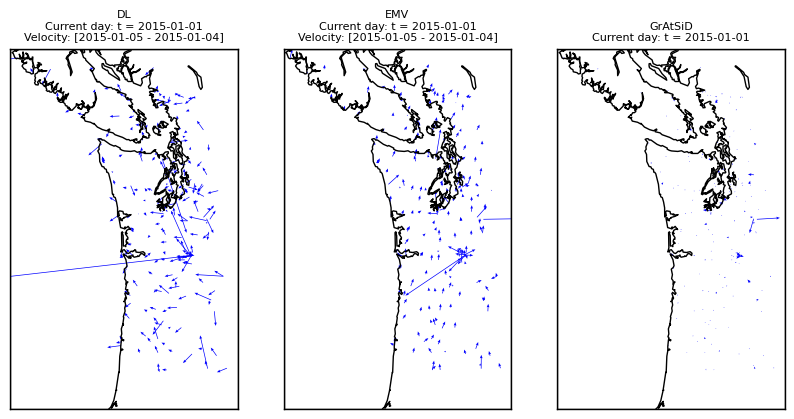

In [85]:
fig, axes = plt.subplots(1,3,figsize=(10,8))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

titles=['DL','EMV','GrAtSiD']
############ First plot ############
for ii in range(3):
    
    Est=[]
    North=[]       
    Latitude=[]
    Longitude=[]
    
    f=0
    
    for k in range(len(Stations[f])):
        station=Stations[f][k][0]
        aa=vel_folder+'/'+str(station)+'.txt' 
        line_number = Stations[f][k][1]
        with open(aa, 'r') as file:
            for _ in range(line_number - 1):
                file.readline()       
            line = file.readline() 
        split_line=line.split()
        Lat=float(filtered_df[filtered_df.station==station].latitude)
        Lon=float(filtered_df[filtered_df.station==station].longitude)

        if ii==0:
            Est.append(split_line[qualiDL[0]])
            North.append(split_line[qualiDL[1]])
        if ii==1:
            Est.append(split_line[qualiEMV[0]])
            North.append(split_line[qualiEMV[1]])
        if ii==2:
            Est.append(split_line[qualiGrAtSiD[0]])
            North.append(split_line[qualiGrAtSiD[1]])

        Latitude.append(Lat)
        Longitude.append(Lon)
    
    
    if ii==0:
        m0 = Basemap(ax=axes[ii],width=Width,height=Height,projection='lcc',
            resolution='i',lat_1=lat_1,lat_2=lat_2,lat_0=lat_0,lon_0=lon_0)
        m0.drawcoastlines()
        m0.drawmapboundary(fill_color='white') 
        x,y = m0(Longitude,Latitude)
        #ha_hor00 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
    if ii==1:
        m1 = Basemap(ax=axes[ii],width=Width,height=Height,projection='lcc',
            resolution='i',lat_1=lat_1,lat_2=lat_2,lat_0=lat_0,lon_0=lon_0)
        m1.drawcoastlines()
        m1.drawmapboundary(fill_color='white') 
        x,y = m1(Longitude,Latitude)
        #ha_hor01 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
    if ii==2:
        m2 = Basemap(ax=axes[ii],width=Width,height=Height,projection='lcc',
            resolution='i',lat_1=lat_1,lat_2=lat_2,lat_0=lat_0,lon_0=lon_0)
        m2.drawcoastlines()
        m2.drawmapboundary(fill_color='white') 
        x,y = m2(Longitude,Latitude)
        #ha_hor02 = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
  
    #axes[ii].set_title(titles[ii]+'\n'+'Current day: t = '+ str(t[f].date())+'\n'+'Velocity: '+ str(t[f+to_end].date())+' - '+str(t[f+to_end-step].date()),fontsize=8) 



ha_hor00 = None
ha_hor01 = None
ha_hor02 = None

def update(f):
    global ha_hor00,ha_hor01,ha_hor02
    for ii in range(3):
        
        #m = Basemap(ax=axes[ii],width=Width,height=Height,projection='lcc',
                #resolution='i',lat_1=lat_1,lat_2=lat_2,lat_0=lat_0,lon_0=lon_0)
        #m.drawcoastlines()
        #m.drawmapboundary(fill_color='white') 
        
        Est=[]
        North=[]       
        Latitude=[]
        Longitude=[]
        
        for k in range(len(Stations[f])):
            station=Stations[f][k][0]
            aa=vel_folder+'/'+str(station)+'.txt' 
            line_number = Stations[f][k][1]
            with open(aa, 'r') as file:
                for _ in range(line_number - 1):
                    file.readline()       
                line = file.readline() 
            split_line=line.split()
            
            if not list(filtered_df[filtered_df.station==station].latitude):
                print(station)
            Lat=float(filtered_df[filtered_df.station==station].latitude)
            Lon=float(filtered_df[filtered_df.station==station].longitude)

            if ii==0:
                Est.append(split_line[qualiDL[0]])
                North.append(split_line[qualiDL[1]])
            if ii==1:
                Est.append(split_line[qualiEMV[0]])
                North.append(split_line[qualiEMV[1]])
            if ii==2:
                Est.append(split_line[qualiGrAtSiD[0]])
                North.append(split_line[qualiGrAtSiD[1]])

            Latitude.append(Lat)
            Longitude.append(Lon)
        
        
        if ii==0:
            x,y = m0(Longitude,Latitude)
            if ha_hor00 is not None:
                ha_hor00.remove()
            ha_hor00 = m0.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
        if ii==1:
            x,y = m1(Longitude,Latitude)
            if ha_hor01 is not None:
                 ha_hor01.remove()
            ha_hor01 = m1.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
        if ii==2:
            x,y = m2(Longitude,Latitude)
            if ha_hor02 is not None:
                ha_hor02.remove()
            ha_hor02 = m2.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
       
        if ii!=2:
            axes[ii].set_title(titles[ii]+'\n'+'Current day: t = '+ str(t[f].date())+'\n'+'Velocity: ['+ str(t[f+to_end].date())+' - '+str(t[f+to_end-step].date())+']',fontsize=8) 
        else:
            axes[ii].set_title(titles[ii]+'\n'+'Current day: t = '+ str(t[f].date()),fontsize=8) 
    return

output_file = cd+"Comparision"+str(input_length)+'_'+str(position)+".mp4"  # You can change the file name if needed
writers = animation.writers
writer = writers['ffmpeg']()
ani = FuncAnimation(fig, update, interval=2, frames=range(len(Stations[:-(to_end+step)]) ))
#ani = FuncAnimation(fig, update, interval=10, frames=range(len(Stations[:20]) ))
ani.save(output_file, writer=writer, dpi=100)

print('End')

In [ ]:
### plt some random examples

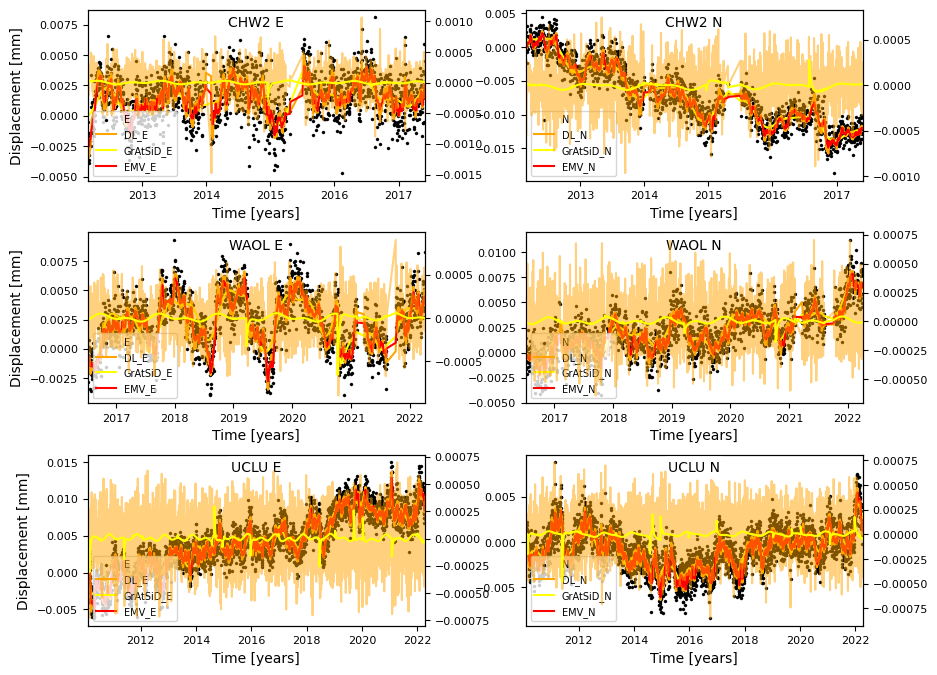

In [70]:
import random
%matplotlib inline
list_stations=id_names_txt(vel_folder)
n_stations=3
stations_to_plot=random.sample(list_stations,n_stations)

fig,ax=plt.subplots(n_stations,len(components),figsize=(10,8))
fig.subplots_adjust(hspace=0.3,wspace=0.3)

for i in range(n_stations):
    station=stations_to_plot[i]
    df_Filterd = pd.read_csv(soln_folder_path+'/'+station+'.txt', delim_whitespace=True,header=None,on_bad_lines='skip',names=names)
    df_Filterd['YYMMDD']= pd.to_datetime(df_Filterd['YYMMDD']).astype('datetime64[ns]')
    df_Filterd['YYMMDD'] = pd.to_datetime(df_Filterd["YYMMDD"]) 
    df_Filterdvel = pd.read_csv(vel_folder+'/'+station+'.txt', delim_whitespace=True,header=None,on_bad_lines='skip',names=names)
    df_Filterdvel['YYMMDD']= pd.to_datetime(df_Filterd['YYMMDD']).astype('datetime64[ns]')
    df_Filterdvel['YYMMDD'] = pd.to_datetime(df_Filterd["YYMMDD"]) 
    for c in range(len(components)):
        ax[i,c].scatter(df_Filterd.YYMMDD,df_Filterd[components[c]],s=5,color='k',linewidth=0.2,label=components[c])
        ax[i,c].plot(df_Filterd.YYMMDD,df_Filterd['DL_'+components[c]],label='DL_'+components[c],color='orange')
        ax[i,c].plot(df_Filterd.YYMMDD,df_Filterd['GrAtSiD_'+components[c]],label='GrAtSiD_'+components[c],color='yellow')
        ax[i,c].plot(df_Filterd.YYMMDD,df_Filterd['EMV_'+components[c]],label='EMV_'+components[c],color='red')
        ax[i,c].set_xlim(df_Filterd.YYMMDD.iloc[0],df_Filterd.YYMMDD.iloc[-1])

        ax[i,c].set_xlabel('Time [years]')
        axo=ax[i,c].twinx()
        axo.plot(df_Filterdvel.YYMMDD,df_Filterdvel['DL_'+components[c]],label='DL_'+components[c],color='orange',alpha=0.5)
        axo.plot(df_Filterdvel.YYMMDD,df_Filterdvel['GrAtSiD_'+components[c]],label='GrAtSiD_'+components[c],color='yellow')
        #axo.plot(df_Filterdvel.YYMMDD,df_Filterdvel['EMV_'+components[c]],label='EMV_'+components[c],color='red',alpha=0.5)

        ax[i,c].legend(loc='lower left',fontsize=7)
        ax[i,c].text(.5,.9,str(station)+' '+components[c],horizontalalignment='center',
                 transform=ax[i,c].transAxes,fontsize=10,\
                 bbox=dict(facecolor='white', edgecolor='w',boxstyle='round'))
               
        ax[i,c].tick_params(axis='x', labelsize=8)
        ax[i,c].set_xlabel('Time [years]')
        ax[i,c].tick_params(axis='y', labelsize=8)
        if c==0:
            ax[i,c].set_ylabel('Displacement [mm]') 
        axo.tick_params(axis='y', labelsize=8)
plt.show()
   

In [55]:
names

['YYMMDD',
 'E',
 'DL_E',
 'EMV_E',
 'GrAtSiD_E',
 'N',
 'DL_N',
 'EMV_N',
 'GrAtSiD_N']

In [46]:
vel_folder

'/home/giacomo/Documents/Cascadia/Filtered_31_29_vel_1d'